In [1]:
import pyemma
import numpy as np
import pyemma.coordinates as coor
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys
import os
from matplotlib.pyplot import cm
from collections import OrderedDict
import mdtraj as md
import itertools
import time
import indices
from indices.base import BaseComparisons as bc
from indices.faith import Faith as Fai
import scipy.cluster.hierarchy as shc
from matplotlib import gridspec
from matplotlib import pyplot
import mdtraj
import seaborn as sns

## Let's try it...

In [2]:
Threshold = 0.6
traj = md.load_dcd('../proteinG_3gb1/yhalfres_0_0/trajectory.00.dcd',top='../proteinG_3gb1/3GB1.pdb')
topfile=traj.top
feat = coor.featurizer(topfile)
residues = np.arange(0,56)
pairs = []                                                                                 
for i,r1 in enumerate(residues):
    for r2 in residues[i+1::2]:
        pairs.append([r1,r2])
pairs = np.array(pairs)
feature=feat.add_residue_mindist(pairs, scheme='closest-heavy',threshold=Threshold,periodic=False)
inp = pyemma.coordinates.load('../proteinG_3gb1/yhalfres_0_0/trajectory.00.dcd', features=feat)

In [3]:
inp=inp[::20]

In [4]:
# %%timeit -n1 -r1 

all_start = time.time()
all_input = list(itertools.combinations(inp, 2))
batch_size=1000000
inp_sliced=[all_input[i*batch_size:(i+1)*batch_size] for i in range(int(len(all_input)/batch_size))]
if int(len(inp_sliced)) < len(all_input)/batch_size:
    inp_sliced.append(all_input[len(inp_sliced)*batch_size:])
for i in range(len(inp_sliced)):
    temp_start = time.time()
    temp_c = np.zeros((int(len(inp_sliced[i])),3))
    temp_input = np.array(inp_sliced[i])
    product = temp_input.reshape(-1,2,temp_input.shape[-1]).sum(1)
    for row in range(3):
        temp_c[:,row] = np.sum(product==row,axis=1)
    if i == 0:
        all_c = temp_c
    else:
        all_c = np.concatenate((all_c,temp_c),axis=0)
    print('all_c shape =', all_c.shape)
    temp_end = time.time()
    temp_time = temp_end - temp_start
    print('step {} time ='.format(i),round(temp_time,2),'s')


###calculate similarity
simi = all_c[:,0]+all_c[:,2]
###try Faith
Faith=False
if Faith:
    faith_simi = 0.5*all_c[:,0]+all_c[:,2]
    denominate = all_c[:,0]+all_c[:,1]+all_c[:,2]
    w_p = faith_simi/denominate
    simi_matrix = np.zeros((len(inp),len(inp)))
    indices = np.triu_indices(len(inp),k=1)
    indices = (indices[1],indices[0])
    simi_matrix[indices] = w_p
else:
    simi_matrix = np.zeros((len(inp),len(inp)))
    indices = np.triu_indices(len(inp),k=1)
    indices = (indices[1],indices[0])
    simi_matrix[indices] = simi
print('final matrix shape = ', simi_matrix.shape)
all_end = time.time()
all_time = all_end - all_start
print('total time =', round(all_time,2),'s')

all_c shape = (124750, 3)
step 0 time = 4.55 s
final matrix shape =  (500, 500)
total time = 4.6 s


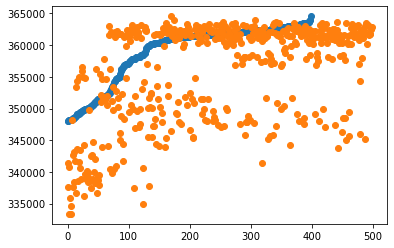

In [5]:
#np.unravel_index(np.argmax(simi, axis=None),simi.shape)
fliped_simi_matrix = np.fliplr(simi_matrix)
mirror_binary_simi=simi_matrix+np.rot90(fliped_simi_matrix)
sum_mirror_binary_simi = np.sum(mirror_binary_simi.T,axis=1)
sum_mirror_binary_simi_index = np.vstack((sum_mirror_binary_simi,range(len(sum_mirror_binary_simi)))).T
outlier_ratio = 0.2
plt.scatter(range(sum_mirror_binary_simi.shape[0]-int(sum_mirror_binary_simi.shape[0]*outlier_ratio)),sorted(sum_mirror_binary_simi)[int(sum_mirror_binary_simi.shape[0]*outlier_ratio):])
plt.scatter(range(sum_mirror_binary_simi.shape[0]),sum_mirror_binary_simi)
plt.scatter(sample_index,sum_mirror_binary_simi[sample_index])
sorted_sum_mirror_binary_simi_index = sum_mirror_binary_simi_index[sum_mirror_binary_simi_index[:,0].argsort()][::-1]
sorted_sum_mirror_binary_simi_index = sorted_sum_mirror_binary_simi_index.astype('int')
index_aa=[]
for index_a,i in enumerate(sum_mirror_binary_simi_index[:,0]):
    if 360000 <i :
        index_aa.append(int(sum_mirror_binary_simi_index[:,1][index_a]))
        

In [12]:
sorted_sum_mirror_binary_simi_index=sum_mirror_binary_simi_index[sum_mirror_binary_simi_index[:,1].argsort()].astype('int')
sorted_sum_mirror_binary_simi_index

array([[341339,      0],
       [337639,      1],
       [333421,      2],
       [340795,      3],
       [335835,      4],
       [334677,      5],
       [333377,      6],
       [348169,      7],
       [342643,      8],
       [337667,      9],
       [343141,     10],
       [338397,     11],
       [341659,     12],
       [336683,     13],
       [353343,     14],
       [354361,     15],
       [343567,     16],
       [338535,     17],
       [341539,     18],
       [355003,     19],
       [340653,     20],
       [343413,     21],
       [338885,     22],
       [355841,     23],
       [356549,     24],
       [354973,     25],
       [344209,     26],
       [336201,     27],
       [339745,     28],
       [354879,     29],
       [338943,     30],
       [338997,     31],
       [340137,     32],
       [339881,     33],
       [338425,     34],
       [349699,     35],
       [338543,     36],
       [338935,     37],
       [337445,     38],
       [342577,     39],


In [9]:
sorted_sum_mirror_binary_simi_index = sum_mirror_binary_simi_index[sum_mirror_binary_simi_index[:,0].argsort()]
sorted_sum_mirror_binary_simi_index = sorted_sum_mirror_binary_simi_index.astype('int')
sorted_sum_mirror_binary_simi_index = sorted_sum_mirror_binary_simi_index[int(sum_mirror_binary_simi.shape[0]*outlier_ratio):]
sample_index=sorted_sum_mirror_binary_simi_index[:,1].tolist()
# simi_matrix = simi_matrix[:,sample_index][sample_index]
# simi_matrix
# inp.shape[0]
len(sample_index)

400

In [38]:
import pandas  as pd
all_start=time.time()
inp_copy=inp#[sample_index]
df = pd.DataFrame(simi_matrix,columns=pd.MultiIndex.from_tuples([('{}'.format(i),'{}'.format(i)) for i in range(1,len(inp_copy)+1)],names=['cluster', 'frame']))
dic={}
hie_tree=[]
dentrom=[]
time_step=[]
while df.shape[0] > 2:
    ###update df
    frame_column=[i[1] for i in df.columns.to_list()]
    hie_tree.append(frame_column)
    new_max=np.argmax(df, axis=None)     ###2.5s

    del_index = np.unravel_index(new_max, df.shape)
    max_value = df.to_numpy()[del_index[0]][del_index[1]] ###0.1s

    ###get temp inp
    delete_row=[int(i) for i in df.columns[del_index[0]][1].split(',') ]
    delete_cluster_row=[int(i) for i in df.columns[del_index[0]][0].split(',')]
    delete_column=[int(i) for i in df.columns[del_index[1]][1].split(',') ]
    delete_cluster_column=[int(i) for i in df.columns[del_index[1]][0].split(',')]
    dentrom.append([*delete_cluster_column,*delete_cluster_row])

    delete_all=delete_column+delete_row
    insert_index='{}'.format(delete_all)[1:-1]   ###0.1s
    insert_cluster_index='{}'.format(2*len(inp) - df.shape[0]+1)
    df.drop(columns=[('{}'.format(delete_cluster_column)[1:-1],'{}'.format(delete_column)[1:-1]),('{}'.format(delete_cluster_row)[1:-1],'{}'.format(delete_row)[1:-1])],axis=1,inplace=True)
    df.drop(index=[*del_index],axis=0,inplace=True)
    df.reset_index(drop=True,inplace=True)
    temp_w_sim=[]            ###1s

    ###get temp inp
   # print(df.columns)
    frame_column=[i[1] for i in df.columns.to_list() ]
    columns=[[int(d) for d in [*i.split(',')]] for i in frame_column]
    temp_inp=[[inp_copy[d-1] for d in m] for m in columns]    ###0.1s

    ###perform comparison
#     if Faith:
#         for i in temp_inp:
#             compare=Fai(np.concatenate(([inp_copy[d-1] for d in delete_all],i),axis=0))
#             temp_w_sim.append(compare.Fai_1sim_wdis)
#     else:
    for i in temp_inp:
       # compare=bc(np.concatenate(([inp_copy[d-1] for d in delete_all],i),axis=0))
        compare=bc(np.concatenate((inp_copy[np.array(delete_all)-1],i),axis=0))
        temp_w_sim.append(compare.total_w_sim)         ###1s

#     temp_start = time.time()
  #  inp_copy = temp_inp
    temp_w_sim=[0]+temp_w_sim
    df.loc[-1] = [0]*df.shape[1] # adding a row
    df.index = df.index + 1  # shifting index
    df = df.sort_index()  # sorting by index
   # print(df.shape)
    if df.shape[0] % 50 == 0:
        all_end = time.time()
        all_time = all_end - all_start
        print('merge {} clusters time ='.format(df.shape[0]), round(all_time,2),'s')
        time_step.append(round(all_time,4))
    df.insert(loc=0, column=(insert_cluster_index,insert_index), value=temp_w_sim)

    dic[insert_index]=max_value
temp_end = time.time() 
temp_time = temp_end - all_start          
print('merge {} clusters time ='.format(df.shape[0]), round(temp_time,2),'s')
time_step.append(round(temp_time,4))
last_two = [int(i[0]) for i in df.columns.to_list()]
dentrogram = np.vstack(dentrom)-np.ones((1,2))
values = np.max(simi_matrix)-np.array([*dic.values()],ndmin=2)+2
num_frames = np.array([len(i) for i in [[int(d) for d in [*k.split(',')]] for k in list(dic.keys())]],ndmin=2)
tree = np.hstack((dentrogram,values.T,num_frames.T))
tree = np.vstack((tree, [[last_two[0]-1,last_two[1]-1,np.max(simi_matrix)-df.to_numpy()[1][0],len(inp)]]))

merge 450 clusters time = 3.99 s
merge 400 clusters time = 7.78 s
merge 350 clusters time = 11.37 s
merge 300 clusters time = 14.59 s
merge 250 clusters time = 17.84 s
merge 200 clusters time = 20.67 s
merge 150 clusters time = 23.37 s
merge 100 clusters time = 26.16 s
merge 50 clusters time = 28.86 s
merge 2 clusters time = 30.44 s


In [39]:
def plot_simi_threshold(tree,p,min_simi,save=False):
    plt.figure(figsize=(20, 8))
    dend = shc.dendrogram(tree,p=p,truncate_mode='lastp')
    plt.axhline(y=min_simi, color='r', linestyle='-')
    plt.xlabel('Num_samples')
    plt.ylabel('Simi_value')
    if save:
        plt.savefig('simi_threshold_tree.png')

def get_step_index(hie_tree,cluster_step):
    label_index = [[int(i)-1 for i in hie_tree[cluster_step][d].split(',')] for d in range(len(hie_tree[cluster_step]))]
    label_index = sorted(label_index, key=lambda x:len(x), reverse=True)
    return label_index
def plot_test_result(true_rmsd,hie_tree,cluster_step,setylim,save=False):
    colors = ['grey', 'purple', 'blue', 'green', 'orange', 'red',
             'black','brown','navy','indigo','cyan','teal','violet','royalblue']
    fig, ax = plt.subplots(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[15, 1]) 
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    label_index = [[int(i)-1 for i in hie_tree[cluster_step][d].split(',')] for d in range(len(hie_tree[cluster_step]))]
    label_index = sorted(label_index, key=lambda x:len(x), reverse=True)
    if len(label_index) > 10:
        label_index = label_index[:10]
    test_rmsd = [[true_rmsd[i] for i in label_index[d]] for d in range(len(label_index))]
    for index,i in enumerate(test_rmsd):
        ax0.scatter(label_index[index],i,marker='.',color=colors[index])
    percentage=[len(i)/len(true_rmsd) for i in test_rmsd]
    sum_percentage = [0.0]+[sum(percentage[:i]) for i in range(1,len(percentage))]+[1.0]
    ax0.set_xlabel('Sample')
    ax0.set_ylabel('RMSD')
    cmap = mpl.colors.ListedColormap(colors[:len(test_rmsd)])
    print(colors[:len(test_rmsd)])
    norm = mpl.colors.BoundaryNorm(sum_percentage, cmap.N)
    cb2 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                    norm=norm,
                                    boundaries=sum_percentage,
                                    ticks=sum_percentage+[1.0],
                                    spacing='proportional')
    cb2.set_label('Cluster samples ratio')
    if setylim:
        ax0.set_ylim(setylim[0],setylim[1])
    if save:
        plt.savefig('simi_threshold_tree.png')
    return label_index

In [26]:
label_index = get_step_index(hie_tree,-4)
len(label_index)

6

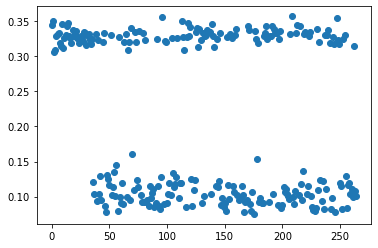

In [56]:
traj = md.load_dcd('../proteinG_3gb1/yhalfres_0_0/trajectory.00.dcd',top='../proteinG_3gb1/3GB1.pdb')
topfile=traj.top
pdb=md.load_pdb('../proteinG_3gb1/3GB1.pdb')
all_CA=topfile.select("backbone==1")
traj=traj[::20]#0][sample_index]
true_rmsd=md.rmsd(traj,pdb,atom_indices=all_CA)
#label_index = plot_test_result(true_rmsd,hie_tree,-4,setylim=[0,1])
plt.scatter(range(len(index_aa)),true_rmsd[index_aa])

In [207]:
import copy 
rest_index = [i for i in range(len(inp)) if i not in list(np.array(range(9998))[::20])]
origi_index = list(np.array(range(len(inp)))[::20])
rest_label_index = copy.deepcopy(label_index)

In [32]:
# all_label_index_bc = [bc(inp_copy[label_index[i]]).total_w_sim for i in range(len(label_index))]
# all_label_index_bc
#[len(rest_label_index[i]) for i in range(len(label_index))]
list(np.array([1,2,34,6,7,4,7,8])[[2,3]])

[34, 6]

(0.0, 1.0)

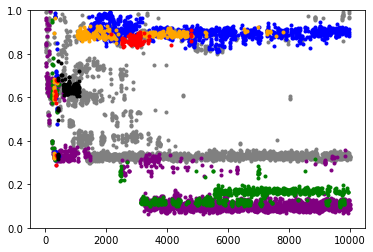

In [211]:
colors = ['grey', 'purple', 'blue', 'green', 'orange', 'red',
             'black','brown','navy','indigo','cyan','teal','violet','royalblue']
traj = md.load_dcd('../proteinG_3gb1/yhalfres_0_0/trajectory.00.dcd',top='../proteinG_3gb1/3GB1.pdb')
for i in range(len(label_index)):
    true_rmsd=md.rmsd(traj[rest_label_index[i]],pdb,atom_indices=all_CA)
    plt.scatter(rest_label_index[i],true_rmsd,color=colors[i],marker='.')
plt.ylim(0,1)

In [209]:
all_start=time.time()
inp = pyemma.coordinates.load('../proteinG_3gb1/yhalfres_0_0/trajectory.00.dcd', features=feat)
rest_inp = inp[rest_index]
for rest_inp_index, d in enumerate(rest_inp):
    change_index = []
    for i in range(len(label_index)):
       # before = bc(inp_copy[label_index[i]]).total_w_sim
        after = bc(np.concatenate((inp_copy[label_index[i]],[d]),axis=0)).total_w_sim
        change = (all_label_index_bc[i] - after)/all_label_index_bc[i]
        change_index.append(change)
        belong_index = np.argmin(change_index)
    if rest_inp_index % 100 == 0:
        print(rest_inp_index, ' finished')
    rest_label_index[belong_index].append(rest_index[rest_inp_index])
temp_end = time.time() 
temp_time = temp_end - all_start  
print('time =', round(temp_time,2),'s')

0  finished
100  finished
200  finished
300  finished
400  finished
500  finished
600  finished
700  finished
800  finished
900  finished
1000  finished
1100  finished
1200  finished
1300  finished
1400  finished
1500  finished
1600  finished
1700  finished
1800  finished
1900  finished
2000  finished
2100  finished
2200  finished
2300  finished
2400  finished
2500  finished
2600  finished
2700  finished
2800  finished
2900  finished
3000  finished
3100  finished
3200  finished
3300  finished
3400  finished
3500  finished
3600  finished
3700  finished
3800  finished
3900  finished
4000  finished
4100  finished
4200  finished
4300  finished
4400  finished
4500  finished
4600  finished
4700  finished
4800  finished
4900  finished
5000  finished
5100  finished
5200  finished
5300  finished
5400  finished
5500  finished
5600  finished
5700  finished
5800  finished
5900  finished
6000  finished
6100  finished
6200  finished
6300  finished
6400  finished
6500  finished
6600  finished
6700  f

(0.0, 2.0)

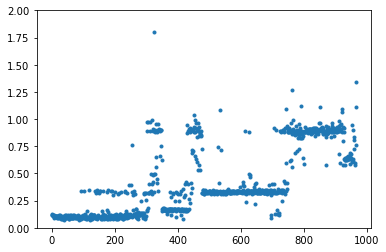

In [150]:
label_concate = np.concatenate(label_index)
traj = md.load_dcd('../proteinG_3gb1/yhalfres_0_0/trajectory.00.dcd',top='../proteinG_3gb1/3GB1.pdb')
topfile=traj.top
pdb=md.load_pdb('../proteinG_3gb1/3GB1.pdb')
all_CA=topfile.select("backbone==1")
rmsd=md.rmsd(traj,pdb,atom_indices=all_CA)
traj_cluster=traj[::10][label_concate]
cluster_rmsd=md.rmsd(traj_cluster,pdb,atom_indices=all_CA)
plt.scatter(range(len(cluster_rmsd)),list(cluster_rmsd),marker='.')
plt.ylim(0,2)

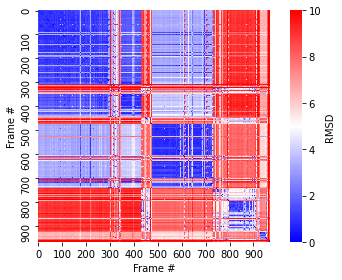

In [152]:
# rmsd_2d=np.zeros((len(traj_cluster),len(traj_cluster)))
# upper_indices = np.triu_indices(len(traj_cluster),k=0)
# lower_indices = (upper_indices[1],upper_indices[0])
# r2d = []
# for i in range(len(traj_cluster)):
#     r2d.append(md.rmsd(traj_cluster[i:],traj_cluster[i],atom_indices=all_CA))
#     if i % 100 == 0:
#         print(i)
# print(np.concatenate(r2d).shape)
# rmsd_2d[lower_indices] = np.concatenate(r2d)
# rmsd_2d[upper_indices] = np.concatenate(r2d)
sns.heatmap(rmsd_2d*10,square=True,xticklabels=100,yticklabels=100,cmap='bwr',cbar_kws={'label':'RMSD'},vmin=0,vmax=10)
plt.xlabel("Frame #")
plt.ylabel("Frame #")
ax = plt.gca()
ax.tick_params(direction='out')
plt.tight_layout()
plt.savefig('test_Faith_1000samples_-40cluster_2drmsd.png')

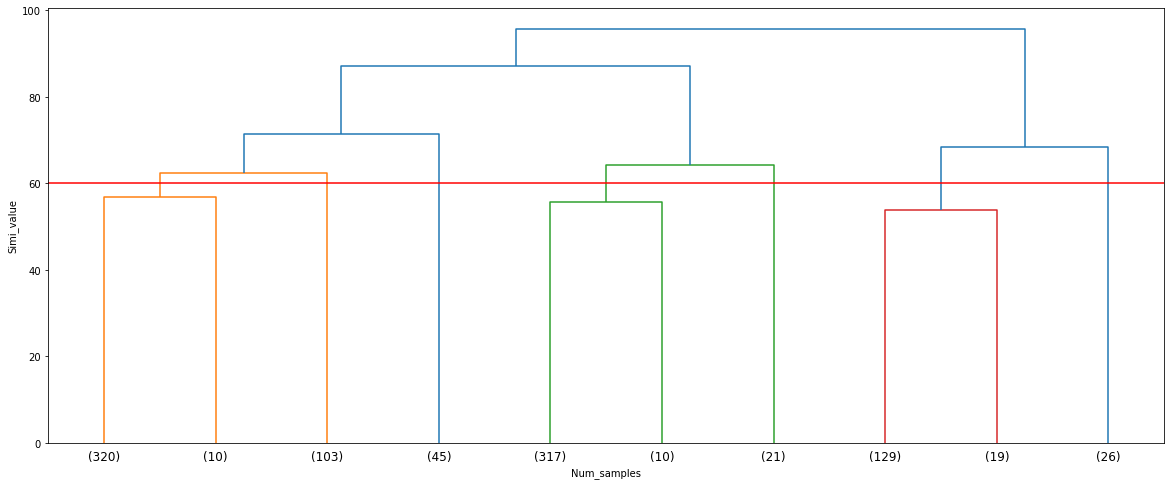

In [94]:
plot_simi_threshold(tree,10,60)

In [23]:
traj = md.load_dcd('../proteinG_3gb1/yhalfres_0_0/trajectory.00.dcd',top='../proteinG_3gb1/3GB1.pdb')
topfile=traj.top
pdb=md.load_pdb('../proteinG_3gb1/3GB1.pdb')
all_CA=topfile.select("backbone==1")
rmsd=md.rmsd(traj[8500],pdb,atom_indices=all_CA)
# plt.scatter(range(len(rmsd)),list(rmsd),marker='.')
# plt.ylim(0,1.5)
rmsd

array([0.35735038], dtype=float32)

Text(0, 0.5, 'RMSD')

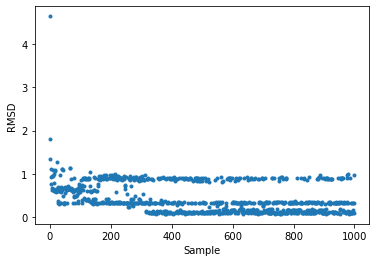

In [143]:
traj=traj[::10]
true_rmsd=md.rmsd(traj,pdb,atom_indices=all_CA)
#list(rmsd)
plt.scatter(range(len(true_rmsd)),list(true_rmsd),marker='.')
plt.xlabel('Sample')
plt.ylabel('RMSD')

In [144]:
def correct_ratio(x):
    unfold = np.sum((x>0.8) & (x<1.8))/x.shape[0]
    intermediate = np.sum((x>0.25) & (x<0.45))/x.shape[0]
    fold = np.sum((x>0.0) & (x<0.25))/x.shape[0]
    molten = np.sum((x>0.45) & (x<0.8))/x.shape[0]
    other = 1-unfold-intermediate-fold-molten
    ratio = [round(unfold,4),round(intermediate,4),round(fold,4),round(molten,4),round(other,4)]
    return ratio

In [145]:
all_clust=[[int(d) for d in [*i.split(',')]] for i in list(dic.keys())]
ave_rmsd = []
all_rmsd = []
for index,i in enumerate(all_clust):
    
    traj_comp=traj[[np.array(i)-1]]
    rmsd=md.rmsd(traj_comp,pdb,atom_indices=all_CA)
    ave_rmsd.append(np.average(rmsd))
    all_rmsd.append(rmsd)
    if index % 100 == 0:
        print(index)
    #print(rmsd)

/home/liweichang/anaconda3/envs/msm/lib/python3.7/site-packages/mdtraj/core/trajectory.py:1129: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  xyz = self.xyz[key]
/home/liweichang/anaconda3/envs/msm/lib/python3.7/site-packages/mdtraj/core/trajectory.py:1130: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  time = self.time[key]


0
100
200
300
400
500
600
700
800
900


In [146]:
correct_ratio(true_rmsd)

[0.252, 0.307, 0.349, 0.091, 0.001]

In [147]:
accuracy=[]
for i in range(len(all_rmsd)):
    if len(all_rmsd[i])>1:
        ratio = correct_ratio(all_rmsd[i])
        print(len(all_rmsd[i]),ratio)#,'|',[*dic.keys()][i])
        accuracy.append(np.max(ratio))

2 [0.0, 0.0, 1.0, 0.0, 0.0]
2 [0.0, 0.0, 1.0, 0.0, 0.0]
2 [0.0, 0.0, 1.0, 0.0, 0.0]
2 [0.0, 0.0, 1.0, 0.0, 0.0]
4 [0.0, 0.0, 1.0, 0.0, 0.0]
6 [0.0, 0.0, 1.0, 0.0, 0.0]
7 [0.0, 0.0, 1.0, 0.0, 0.0]
8 [0.0, 0.0, 1.0, 0.0, 0.0]
9 [0.0, 0.0, 1.0, 0.0, 0.0]
10 [0.0, 0.0, 1.0, 0.0, 0.0]
11 [0.0, 0.0, 1.0, 0.0, 0.0]
12 [0.0, 0.0, 1.0, 0.0, 0.0]
13 [0.0, 0.0, 1.0, 0.0, 0.0]
14 [0.0, 0.0, 1.0, 0.0, 0.0]
15 [0.0, 0.0, 1.0, 0.0, 0.0]
16 [0.0, 0.0, 1.0, 0.0, 0.0]
17 [0.0, 0.0, 1.0, 0.0, 0.0]
18 [0.0, 0.0, 1.0, 0.0, 0.0]
19 [0.0, 0.0, 1.0, 0.0, 0.0]
20 [0.0, 0.0, 1.0, 0.0, 0.0]
21 [0.0, 0.0, 1.0, 0.0, 0.0]
22 [0.0, 0.0, 1.0, 0.0, 0.0]
23 [0.0, 0.0, 1.0, 0.0, 0.0]
24 [0.0, 0.0, 1.0, 0.0, 0.0]
25 [0.0, 0.0, 1.0, 0.0, 0.0]
26 [0.0, 0.0, 1.0, 0.0, 0.0]
27 [0.0, 0.0, 1.0, 0.0, 0.0]
28 [0.0, 0.0, 1.0, 0.0, 0.0]
29 [0.0, 0.0, 1.0, 0.0, 0.0]
30 [0.0, 0.0, 1.0, 0.0, 0.0]
31 [0.0, 0.0, 1.0, 0.0, 0.0]
32 [0.0, 0.0, 1.0, 0.0, 0.0]
33 [0.0, 0.0, 1.0, 0.0, 0.0]
34 [0.0, 0.0, 1.0, 0.0, 0.0]
35 [0.0, 0.0, 1.0, 0.0,

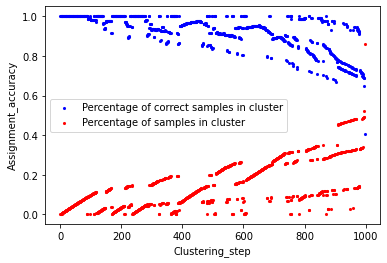

In [153]:
num_frames = np.array([len(i) for i in [[int(d) for d in [*k.split(',')]] for k in list(dic.keys())]],ndmin=2)
plt.scatter(range(len(accuracy)),accuracy,marker='.',linewidths=0.1,color='b',label='Percentage of correct samples in cluster')
plt.scatter(range(num_frames.shape[1]),*(num_frames/num_frames.shape[1]).tolist(),marker='.',linewidths=0.1,color='r',label='Percentage of samples in cluster')
#plt.scatter(*(num_frames).tolist(),accuracy,marker='.',color='r')

plt.xlabel('Clustering_step')
plt.ylabel('Assignment_accuracy')
plt.legend()
plt.savefig('test_Faith_proteinG_1000samples_accuracy.png')

In [189]:
for i in range(-10,0):
    print(len(all_clust[i]),'|',round(ave_rmsd[i],3),'|',round([*dic.values()][i],3))

125 | 0.586 | 758.328
79 | 0.602 | 758.101
25 | 0.571 | 758.08
12 | 0.78 | 757.833
89 | 0.599 | 757.629
16 | 0.541 | 757.625
185 | 0.632 | 757.6
12 | 0.656 | 757.5
191 | 0.579 | 757.257
2 | 0.971 | 757.0


In [112]:
len([*[*dic.keys()][99].split(',')])

897

## We will try k-means++ from here

In [376]:
Threshold = 0.6
traj = md.load_dcd('../proteinG_3gb1/yhalfres_0_0/trajectory.00.dcd',top='../proteinG_3gb1/3GB1.pdb')
topfile=traj.top
feat = coor.featurizer(topfile)
residues = np.arange(0,56)
pairs = []                                                                                 
for i,r1 in enumerate(residues):
    for r2 in residues[i+1::2]:
        pairs.append([r1,r2])
pairs = np.array(pairs)
feature=feat.add_residue_mindist(pairs, scheme='closest-heavy',threshold=Threshold,periodic=False)
inp = pyemma.coordinates.load('../proteinG_3gb1/yhalfres_0_0/trajectory.00.dcd', features=feat)
inp=inp[::10]
traj = traj[::10]

In [394]:
all_start = time.time()
all_input = list(itertools.combinations(inp, 2))
batch_size=1000000
inp_sliced=[all_input[i*batch_size:(i+1)*batch_size] for i in range(int(len(all_input)/batch_size))]
if int(len(inp_sliced)) < len(all_input)/batch_size:
    inp_sliced.append(all_input[len(inp_sliced)*batch_size:])
for i in range(len(inp_sliced)):
    temp_start = time.time()
    temp_c = np.zeros((int(len(inp_sliced[i])),3))
    temp_input = np.array(inp_sliced[i])
    product = temp_input.reshape(-1,2,temp_input.shape[-1]).sum(1)
    for row in range(3):
        temp_c[:,row] = np.sum(product==row,axis=1)
    if i == 0:
        all_c = temp_c
    else:
        all_c = np.concatenate((all_c,temp_c),axis=0)
    print('all_c shape =', all_c.shape)
    temp_end = time.time()
    temp_time = temp_end - temp_start
    print('step {} time ='.format(i),round(temp_time,2),'s')

###calculate similarity
simi = all_c[:,0]+all_c[:,2]
disimi = all_c[:,1]
denominate = all_c[:,0]+all_c[:,1]+all_c[:,2]
w_p = simi/denominate
simi_matrix = np.zeros((len(inp),len(inp)))
mirror_simi_matrix = np.zeros((len(inp),len(inp)))
upper_indices = np.triu_indices(len(inp),k=1)
lower_indices = (upper_indices[1],upper_indices[0])
simi_matrix[lower_indices] = simi
mirror_simi_matrix[upper_indices] = simi
mirror_simi_matrix[lower_indices] = simi
np.fill_diagonal(mirror_simi_matrix,np.Inf)
print('final matrix shape = ', simi_matrix.shape)
all_end = time.time()
all_time = all_end - all_start
print('total time =', round(all_time,2),'s')

all_c shape = (499500, 3)
step 0 time = 5.27 s
final matrix shape =  (1000, 1000)
total time = 5.35 s


In [403]:
#centroid = np.random.randint(0,len(inp),3)
centroid = [243,804,382]

In [408]:
### Assigning the most similar sample to each centroid
mirror_max_matrix = np.zeros((len(inp),len(inp)))
mirror_max_matrix[upper_indices] = simi
mirror_max_matrix[lower_indices] = simi
max_index = np.argmax(mirror_max_matrix[:,centroid],axis=0)
first_step = [[centroid[index],max_index[index]] for index in range(len(max_index))]
second_step_index = [i for i in range(inp.shape[0]) if i not in list(np.concatenate(first_step))]
print(first_step)

[[243, 215], [804, 793], [382, 914]]


In [409]:
md.rmsd(traj[np.concatenate(first_step)],pdb,atom_indices=all_CA)

array([0.87399685, 0.8820699 , 0.33895   , 0.33139157, 0.07938181,
       0.08370326], dtype=float32)

In [410]:
all_start = time.time()
k_clusters = [[243, 215], [804, 793], [382, 914]]
while len(second_step_index) > 0:
    random_int = np.random.randint(0,len(second_step_index))
    single = second_step_index[random_int]
    k_max = np.argmax([bc(np.concatenate(([inp[single]],inp[k_clusters[k]]),axis=0)).total_w_sim for k in range(len(k_clusters))],axis=None)
#    k_max = np.argmax([Fai(np.concatenate(([inp[single]],inp[k_clusters[k]]),axis=0)).Fai_1sim_wdis for k in range(len(k_clusters))],axis=None)
    k_clusters[k_max] = k_clusters[k_max] + [single]
    second_step_index.remove(single)
all_end = time.time()
all_time = all_end - all_start
print('total time =', round(all_time,2),'s')

total time = 4.08 s


In [411]:
print([len(i) for i in k_clusters])
[correct_ratio(md.rmsd(traj[i],pdb,atom_indices=all_CA)) for i in k_clusters]

[209, 140, 651]


[[0.8325, 0.0622, 0.0574, 0.0478, -0.0],
 [0.1143, 0.4643, 0.2857, 0.1286, 0.0071],
 [0.0952, 0.3518, 0.4562, 0.0968, 0.0]]

In [ ]:
### compare triple array
for k in range(len(first_step)):
    a=np.zeros((len(second_step_index),len(first_step[k])+1))
    a[:,0] = second_step_index
    a[:,[1,2]] = first_step[k]
    a=a.astype('int')
    all_input = [inp[i] for i in a]
    all_array_input = np.vstack([all_input])
    all_product = all_array_input.reshape(-1,3,all_array_input.shape[-1]).sum(1)
    temp_c = np.zeros((len(second_step_index),len(first_step[0])+2))
    for row in range(len(first_step[0])+2):
        temp_c[:,row] = np.sum(all_product==row,axis=1)
    if k == 0:
        all_c = temp_c
    else:
        all_c = np.concatenate((all_c,temp_c),axis=0)
        
### find centroids step by step
min_index = (np.argmin(mirror_simi_matrix[:,first_centroid]),first_centroid)
centroid = [first_centroid]
k=2
for i in range(k):
    ave_array = np.average(mirror_simi_matrix[:,centroid],axis=1)
    print(ave_array.shape)
    min_index = np.argmin(ave_array)
    centroid.append(min_index)
    print(centroid)
centroid

## Here is the playground

In [396]:
all_data=np.loadtxt('test_data/aggregation.txt')
all_data=all_data[:,0:2]
pairs = list(itertools.combinations(all_data, 2))

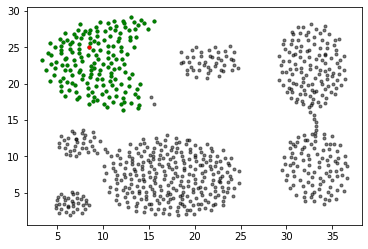

In [425]:
plt.scatter(all_data[:,0],all_data[:,1],marker='.',color='k',alpha=0.5)
#plt.scatter(all_data[:,0][peak_list[0]],all_data[:,1][peak_list[0]],marker='x',color='r')
#plt.scatter(all_data[:,0][rough_peaks],all_data[:,1][rough_peaks],marker='.',color='r')
plt.scatter(all_data[:,0][index_aa],all_data[:,1][index_aa],marker='.',color='g')
plt.scatter(all_data[:,0][49],all_data[:,1][49],marker='.',color='r')
# plt.scatter(all_data[:,0][trial_step_path[0]],all_data[:,1][trial_step_path[0]],marker='.',color='r')

# for i in trial_step_nn[-8:-1]:
#     plt.scatter(all_data[:,0][i],all_data[:,1][i],marker='.')
# for i in clusters:
#     plt.scatter(all_data[:,0][i],all_data[:,1][i],marker='.')
  

In [418]:
peak_list

array([311, 699, 513,  49, 721, 178, 757])

In [398]:
import time
import copy
#step_1: calculate distance matrix
def calc_distance_matrix(all_data,cutoff):
    pairs = list(itertools.combinations(all_data, 2))
    simi_matrix = np.zeros((len(all_data),len(all_data)))
    mirror_simi_matrix = np.zeros((len(all_data),len(all_data)))
    upper_indices = np.triu_indices(len(all_data),k=1)
    lower_indices = (upper_indices[1],upper_indices[0])
    pair_array = np.array(pairs)
    distance=np.linalg.norm(pair_array[:,0]-pair_array[:,1],axis=1)
    distance_cut=distance<cutoff
    simi_matrix[lower_indices] = distance_cut
    mirror_simi_matrix[upper_indices] = distance_cut
    mirror_simi_matrix[lower_indices] = distance_cut
    np.fill_diagonal(mirror_simi_matrix,1)    
    sum_mirror_binary_simi = np.sum(mirror_simi_matrix.T,axis=1)
    normed_sum_mirror_binary_simi = np.exp(sum_mirror_binary_simi/sum_mirror_binary_simi.max())
    distance_matrix = np.zeros((len(all_data),len(all_data)))
    distance_matrix[upper_indices] = distance
    distance_matrix[lower_indices] = distance
    return distance_matrix, normed_sum_mirror_binary_simi,mirror_simi_matrix

#step_2: build k-nearest-neighbor matrix
def build_knn(high_rho_distance_matrix, k, start_point):
    copy_distance_matrix = copy.copy(high_rho_distance_matrix)
    shape = copy_distance_matrix.shape[0]
    no_knn_list = np.argsort(copy_distance_matrix,axis=1)[:,k+1:]
    np.put_along_axis(copy_distance_matrix,no_knn_list,np.inf,axis=1)
    single_source_path = copy_distance_matrix[start_point]
    nn = True
    all_nn = np.concatenate(np.argwhere((single_source_path != np.inf) & (single_source_path != 0)).T)

    while nn == True:
        old_single_source_path = copy.copy(single_source_path)
        for nn_index,i in enumerate(all_nn):
            current_stage = np.concatenate(np.argwhere(old_single_source_path != np.inf).T)
            another_path = copy_distance_matrix[i].reshape(copy_distance_matrix.shape[0],)
            next_nn = np.concatenate(np.argwhere((another_path != np.inf) & (another_path != np.inf)).T)
            for ii in next_nn:
                if another_path[ii] != np.inf:
                    single_source_path[ii] = np.min((single_source_path[ii], single_source_path[i] + another_path[ii]))
            if nn_index == 0:
                temp_nn = copy.copy(next_nn)
            else:
                temp_nn = np.concatenate((temp_nn, next_nn),axis=None)

        all_nn = np.array([d for d in np.unique(temp_nn) if d not in current_stage])
        if all_nn.shape[0] == 0:
            nn = False

    return single_source_path     

#step_3: decide density peaks and get clusters simultaneously
def get_peaks(num_peaks, distance_matrix, normed_sum_mirror_binary_simi,mirror_simi_matrix, k, ambiguity=0.3):
    sum_mirror_binary_simi = np.sum(mirror_simi_matrix,axis=1)
    sum_mirror_binary_simi_index = np.vstack((sum_mirror_binary_simi,range(len(sum_mirror_binary_simi)))).T
    sorted_sum_mirror_binary_simi_index = sum_mirror_binary_simi_index[sum_mirror_binary_simi_index[:,0].argsort()][::-1]
    sorted_sum_mirror_binary_simi_index = sorted_sum_mirror_binary_simi_index.astype('int')
    index_aa=list(sorted_sum_mirror_binary_simi_index[:,1][:int(distance_matrix.shape[0]*(1-ambiguity))])
    high_rho_distance_matrix = distance_matrix[index_aa][:,index_aa]
    high_rho_normed_sum_mirror_binary_simi = normed_sum_mirror_binary_simi[index_aa]
    normed_min_max = []
    rough_peaks = []
    peak_list = []
    for peak in range(num_peaks):
        if peak == 0:
            new_peak = high_rho_normed_sum_mirror_binary_simi.argmax()
            peak_list.append(new_peak)
            rough_peaks.append(new_peak)
            all_paths = build_knn(high_rho_distance_matrix, k, new_peak)
        elif peak == 1:
            big_dis = high_rho_distance_matrix[peak_list[0]]/(high_rho_distance_matrix[peak_list[0]].max())
            new_peak = (high_rho_normed_sum_mirror_binary_simi*big_dis).argmax()
            peak_list.append(new_peak)
            normed_min_max.append((high_rho_normed_sum_mirror_binary_simi*big_dis).max())
            all_paths = np.concatenate(([all_paths],[build_knn(high_rho_distance_matrix, k, new_peak)]),axis=0)
            rough_peaks.append(new_peak)
            
        else:
            min_max = np.min(high_rho_distance_matrix[rough_peaks],axis=0)/np.max(high_rho_distance_matrix[rough_peaks],axis=0)
            min_max[rough_peaks] = 0
            new_peak = (high_rho_normed_sum_mirror_binary_simi*min_max).argmax()
            rough_peaks.append(new_peak)
            single_source_path = build_knn(high_rho_distance_matrix, k, new_peak)
            
            if (single_source_path[peak_list]==np.inf).sum() == len(peak_list):
                peak_list.append(new_peak)
                normed_min_max.append((high_rho_normed_sum_mirror_binary_simi*min_max).max())
                all_paths = np.concatenate((all_paths,[single_source_path]),axis=0)
            else:
                normed_min_max.append(0)
    
    rough_peaks = np.array(index_aa)[rough_peaks]
    peak_list = np.array(index_aa)[peak_list]
    clusters = [np.array(index_aa)[all_paths[a]!=np.inf] for a in range(all_paths.shape[0])]
    
    return index_aa,peak_list,rough_peaks,normed_min_max,all_paths,clusters

 

$argmax(\frac{min(\text{distances to previous determined cluster centers})}{max(\text{distances to previous determined cluster centers})}*e^{\text{normed density}})$

In [410]:
all_start = time.time()
distance_matrix, normed_sum_mirror_binary_simi,mirror_simi_matrix = calc_distance_matrix(all_data,3)
index_aa,peak_list,rough_peaks,normed_min_max,all_paths,clusters = get_peaks(15, distance_matrix, normed_sum_mirror_binary_simi,mirror_simi_matrix, 4,ambiguity=0.23)


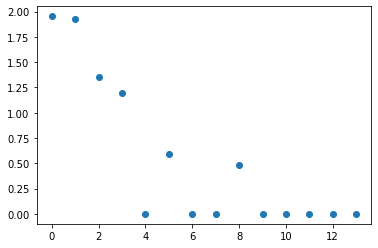

In [411]:
plt.scatter(range(len(normed_min_max)), normed_min_max)

In [174]:
peak_list

array([ 90, 210, 184])

In [422]:
all_start = time.time()

def build_knn(distance_matrix,mirror_simi_matrix, k, start_point):
    sum_mirror_binary_simi = np.sum(mirror_simi_matrix,axis=1)
    copy_distance_matrix = copy.copy(distance_matrix)
    shape = copy_distance_matrix.shape[0]
    no_knn_list = np.argsort(copy_distance_matrix,axis=1)[:,k+1:]
    np.put_along_axis(copy_distance_matrix,no_knn_list,np.inf,axis=1)
    single_source_path = copy_distance_matrix[start_point]
    search_num = copy.copy(k)
    nn = True
    ppp=0
    all_nn = np.concatenate(np.argwhere((single_source_path != np.inf) & (single_source_path != 0)).T)
    step_nn=[]
    step_min_max_rho=[]
    
    step_short_path=dict(zip(list(all_nn), [[i] for i in all_nn]))
    while nn == True:
        print(step_short_path)
        print(all_nn)
#         for nnn in all_nn:
        old_single_source_path = copy.copy(single_source_path)
        for nn_index,i in enumerate(all_nn):
            
            current_stage = np.concatenate(np.argwhere(old_single_source_path != np.inf).T)
#             print(current_stage)

            another_path = copy_distance_matrix[i].reshape(copy_distance_matrix.shape[0],)
            next_nn = np.concatenate(np.argwhere((another_path != np.inf) & (another_path != np.inf)).T)
#             print(next_nn)
            for ii in next_nn:
               # if another_path[ii] != np.inf:
                if single_source_path[i] + another_path[ii] < single_source_path[ii]:
                    single_source_path[ii] = single_source_path[i] + another_path[ii]
                    print(i)
                    step_short_path.update({ii:step_short_path[i] + [ii]})#[ii] = step_short_path[i] + [ii]
                    #single_source_path[ii] = np.min((single_source_path[ii], single_source_path[i] + another_path[ii]))
#             print(np.argwhere(single_source_path != np.inf)[0])
            if nn_index == 0:
                temp_nn = copy.copy(next_nn)
            else:
                temp_nn = np.concatenate((temp_nn, next_nn),axis=None)
#         print(np.unique(temp_nn))
#         print(current_stage)
        all_nn = np.array([d for d in np.unique(temp_nn) if d not in current_stage])
        step_nn.append(all_nn)
#        step_min_max_rho.append(sum_mirror_binary_simi[all_nn.tolist()].max()/sum_mirror_binary_simi[all_nn.tolist()].min())
        print(step_min_max_rho)
        ppp+=1
#         print(ppp)
        if all_nn.shape[0] != 0:
            step_nn.append(all_nn)
            step_min_max_rho.append(np.average(sum_mirror_binary_simi[list(all_nn)]))
        else:
            nn = False
            break

    return single_source_path, step_nn, step_min_max_rho, step_short_path
            
            

In [423]:
distance_matrix, normed_sum_mirror_binary_simi,mirror_simi_matrix = calc_distance_matrix(all_data,3)
the_trial_path,trial_step_nn,trial_step_min_max_rho,trial_step_path=build_knn(distance_matrix,mirror_simi_matrix,4,49)
all_end = time.time()
all_time = all_end - all_start
index_aa = np.array(range(distance_matrix.shape[0]))[the_trial_path!=np.inf]
print(round(all_time,2),'s')

{46: [46], 47: [47], 48: [48], 50: [50]}
[46 47 48 50]
46
46
47
48
48
50
50
50
[]
{46: [46], 47: [47], 48: [48], 50: [50], 33: [46, 33], 45: [47, 45], 32: [48, 32], 51: [50, 51], 56: [50, 56], 57: [50, 57]}
[32 33 45 51 56 57]
32
32
33
45
51
56
57
57
[43.5]
{46: [46], 47: [47], 48: [48], 50: [50], 33: [46, 33], 45: [47, 45], 32: [48, 32], 51: [50, 51], 56: [50, 56], 57: [50, 57], 24: [48, 32, 24], 31: [48, 32, 31], 34: [46, 33, 34], 38: [47, 45, 38], 52: [50, 51, 52], 55: [50, 56, 55], 72: [50, 57, 72], 81: [50, 57, 81]}
[24 31 34 38 52 55 72 81]
24
24
24
31
34
34
38
38
38
52
52
55
55
55
72
72
81
81
[43.5, 40.875]
{46: [46], 47: [47], 48: [48], 50: [50], 33: [46, 33], 45: [47, 45], 32: [48, 32], 51: [50, 51], 56: [50, 56], 57: [50, 57], 24: [48, 32, 24], 31: [48, 32, 31], 34: [46, 33, 34], 38: [47, 45, 38], 52: [50, 51, 52], 55: [50, 56, 55], 72: [50, 57, 72], 81: [50, 57, 81], 19: [48, 32, 24, 19], 23: [48, 32, 24, 23], 25: [48, 32, 24, 25], 30: [48, 32, 31, 30], 35: [46, 33, 34, 35],

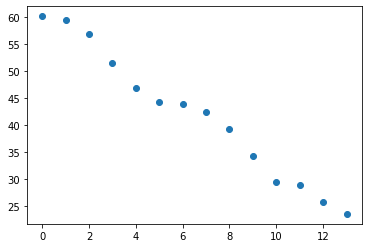

In [93]:
# plt.scatter(range(len(trial_step_min_max_rho)), trial_step_min_max_rho)


In [335]:
#pairs = list(itertools.combinations(, 2))
simi_matrix = np.zeros((len(all_data),len(all_data)))
mirror_simi_matrix = np.zeros((len(all_data),len(all_data)))
upper_indices = np.triu_indices(len(all_data),k=1)
lower_indices = (upper_indices[1],upper_indices[0])
pair_array = np.array(pairs)
distance=np.linalg.norm(pair_array[:,0]-pair_array[:,1],axis=1)
distance_cut=distance<3
simi_matrix[lower_indices] = distance_cut
mirror_simi_matrix[upper_indices] = distance_cut
mirror_simi_matrix[lower_indices] = distance_cut
np.fill_diagonal(mirror_simi_matrix,1)
# mirror_simi_matrix=mirror_simi_matrix[index_aa][:,index_aa]
print(mirror_simi_matrix.shape)

(788, 788)


In [336]:
sum_mirror_binary_simi = np.sum(mirror_simi_matrix.T,axis=1)
normed_sum_mirror_binary_simi = np.exp(sum_mirror_binary_simi/sum_mirror_binary_simi.max())
distance_matrix = np.zeros((len(all_data),len(all_data)))
distance_matrix[upper_indices] = distance
distance_matrix[lower_indices] = distance
# distance_matrix = distance_matrix[index_aa][:,index_aa]
normed_sum_mirror_binary_simi = normed_sum_mirror_binary_simi
# normed_sum_mirror_binary_simi

In [198]:
# normed_min_max = []
# peak_list = []
# for i in range(30):
#     if i == 0:
#         peak_list.append(normed_sum_mirror_binary_simi.argmax())
#     elif i == 1:
#         big_dis = distance_matrix[peak_list[0]]/(distance_matrix[peak_list[0]].max())
#         peak_list.append((normed_sum_mirror_binary_simi*big_dis).argmax())
#         normed_min_max.append((normed_sum_mirror_binary_simi*big_dis).max())
#     else:
#         min_max = np.min(distance_matrix[[peak_list]],axis=0)/np.max(distance_matrix[[peak_list]],axis=0)
#         for i in peak_list:
#             min_max[i] = 0
#         peak_list.append((normed_sum_mirror_binary_simi*min_max).argmax())
#         normed_min_max.append((normed_sum_mirror_binary_simi*min_max).max())


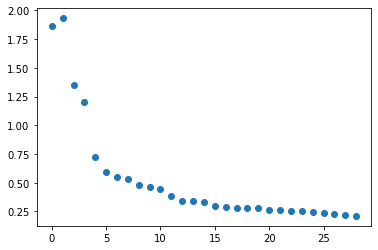

In [67]:
# big_dis = distance_matrix[313]/distance_matrix[313].max()#+mirror_binary_dissimi[123]+mirror_binary_dissimi[294]+mirror_binary_dissimi[636]+ \
# #            #mirror_binary_dissimi[392]+mirror_binary_dissimi[259] #/sum_mirror_binary_simi
# # # big_dis[371]=np.inf
# # # big_dis_max = big_dis.max()
# # # plt.scatter(sum_mirror_binary_simi,mirror_binary_dissimi[371])
# # # mirror_binary_dissimi[371][123]
# # # plt.scatter(range(len(sorted(sum_mirror_binary_simi*mirror_binary_dissimi[371]))),sorted(sum_mirror_binary_simi*mirror_binary_dissimi[371]))
# plt.scatter(range(len(sorted(normed_sum_mirror_binary_simi*min_max))),sorted(normed_sum_mirror_binary_simi*min_max))
# (normed_sum_mirror_binary_simi*min_max).argmax()
plt.scatter(range(len(normed_min_max)),normed_min_max)


In [199]:
from clustering import *
simi_matrix , dis_matrix, time= binary_simi_matrix(mirror_simi_matrix,simi_scale = 'scaled',scale=0)
mirror_binary_dissimi=dis_matrix+np.rot90(np.fliplr(dis_matrix))
sum_mirror_binary_simi = np.sum(mirror_simi_matrix,axis=1)

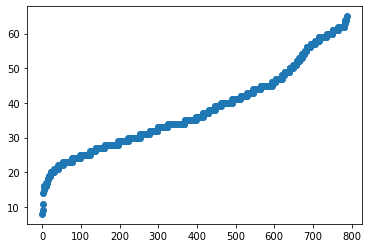

In [200]:
plt.scatter(range(sum_mirror_binary_simi.shape[0]),sorted(sum_mirror_binary_simi))
index_aa=[]
for index_a,i in enumerate(sum_mirror_binary_simi):
    if sum_mirror_binary_simi[index_a]>30:# and 770<sum_mirror_binary_simi[index_a] < 1000:
        index_aa.append(index_a)   

In [202]:
index_aa

[14,
 16,
 19,
 20,
 23,
 24,
 25,
 26,
 27,
 29,
 30,
 31,
 32,
 33,
 34,
 37,
 38,
 39,
 40,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 63,
 65,
 66,
 67,
 70,
 71,
 72,
 73,
 77,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 110,
 111,
 113,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 178,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 197,
 198,
 199,
 200,
 201,
 203,
 207,
 210,
 211,
 212,
 214,
 215,
 216,
 220,
 221,
 222,
 223,
 224,
 225,
 226,
 227,
 228,
 229,
 230,
 231,
 234,
 235,
 236,
 237,
 238,
 239,
 240,
 241,
 242,
 243,
 244,
 245,
 246,
 247,
 248,
 249,
 250,
 251,
 252,
 253,
 254,
 255,
 256,
 257,
 258,
 259,
 260,
 261,
 262,
 263,
 264,
 265,
 266,
 267,
 268,
 269,
 272,
 273,
 274,
 275,
 276,
 277,
 278,
 2

In [203]:
sum_mirror_binary_simi_index = np.vstack((sum_mirror_binary_simi,range(len(sum_mirror_binary_simi)))).T

In [204]:
sorted_sum_mirror_binary_simi_index = sum_mirror_binary_simi_index[sum_mirror_binary_simi_index[:,0].argsort()][::-1]
sorted_sum_mirror_binary_simi_index = sorted_sum_mirror_binary_simi_index.astype('int')
sorted_sum_mirror_binary_simi_index

array([[ 65, 311],
       [ 64, 381],
       [ 64, 314],
       ...,
       [ 11, 165],
       [  9,   0],
       [  8, 166]])

In [10]:
all_compare=[]
for i in range(1,len(all_data)):
    all_compare+=list(itertools.combinations(np.vstack((mirror_simi_matrix[sorted_sum_mirror_binary_simi_index[:,1][i]],mirror_simi_matrix[[sorted_sum_mirror_binary_simi_index[:,1][:i]]])),2))[:i]


/home/liweichang/anaconda3/envs/msm/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  This is separate from the ipykernel package so we can avoid doing imports until


In [167]:
all_input = all_compare
batch_size=1000000
inp_sliced=[all_input[i*batch_size:(i+1)*batch_size] for i in range(int(len(all_input)/batch_size))]
if int(len(inp_sliced)) < len(all_input)/batch_size:
    inp_sliced.append(all_input[len(inp_sliced)*batch_size:])
for i in range(len(inp_sliced)):
    temp_c = np.zeros((int(len(inp_sliced[i])),3))
    temp_input = np.array(inp_sliced[i])
    product = temp_input.reshape(-1,2,temp_input.shape[-1]).sum(1)
    for row in range(3):
        temp_c[:,row] = np.sum(product==row,axis=1)
    if i == 0:
        all_c = temp_c
    else:
        all_c = np.concatenate((all_c,temp_c),axis=0)

###calculate similarity

simi = all_c[:,0]+all_c[:,2]
dis_simi = all_c[:,1]

simi_matrix = np.zeros((len(all_data),len(all_data)))
dis_simi_matrix = np.zeros((len(all_data),len(all_data)))
indices = np.triu_indices(len(all_data),k=1)
indices = (indices[1],indices[0])
simi_matrix[indices] = simi
dis_simi_matrix[indices] = dis_simi

In [168]:
upper_indices = np.triu_indices(len(all_data),k=1)
dis_simi_matrix[upper_indices] = np.Inf
np.fill_diagonal(dis_simi_matrix,np.Inf)
min_dis_simi = np.min(dis_simi_matrix,axis=1)
min_dis_simi[0] = min_dis_simi[1:].max()
dis_simi_matrix[0] = dis_simi_matrix.max()
dis_all = np.vstack((min_dis_simi,sorted_sum_mirror_binary_simi_index[:,1])).T

In [169]:
sorted_dis_all = dis_all[dis_all[:,1].argsort()]
sorted_dis_all

array([[  4.,   0.],
       [  8.,   1.],
       [  6.,   2.],
       ...,
       [  5., 785.],
       [  5., 786.],
       [  4., 787.]])

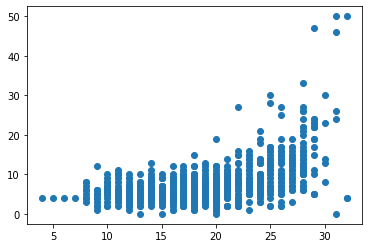

In [170]:
plt.scatter(sum_mirror_binary_simi,sorted_dis_all[:,0])

In [176]:
index_aa=[]
for index_a,i in enumerate(sorted_dis_all[:,0]):
    if i > 20 and sum_mirror_binary_simi[index_a]>25:# and 770<sum_mirror_binary_simi[index_a] < 1000:
        index_aa.append(index_a)      